# Credit Scoring PoC - Business Demo

## Problem Statement
- Traditional credit assessment: **2-4 weeks**, manual review, expensive
- **Our solution:** Automated credit scoring in **seconds**
- **Impact:** Speed up decisions, reduce costs, better risk management

In [9]:
import sys
sys.path.insert(0, '/Users/surface/Documents/Oman/credit_score/backend')

import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Import our scoring functions
from simple_credit_score import (
    calculate_statistical_credit_score,
    get_user_data,
    score_user
)

# Set styling for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All dependencies loaded successfully!")

✓ All dependencies loaded successfully!


## Sample Customer Data

Let's look at some real customers in our database:

In [10]:
# Load sample customers
data_file = Path('/Users/surface/Documents/Oman/credit_score/data/user_data.json')
with open(data_file, 'r') as f:
    all_users = json.load(f)

# Get unique customers
unique_customers = {}
for user in all_users:
    cid = user['Customer_ID']
    if cid not in unique_customers:
        unique_customers[cid] = user

# Sample 3 different customers
sample_ids = [3392, 8625, 38382]
sample_data = []

for user in all_users[:500]:  # Find our sample customers
    if user['Customer_ID'] in sample_ids and user['Customer_ID'] not in [s['Customer_ID'] for s in sample_data]:
        sample_data.append(user)

# Display sample customers
for customer in sample_data[:3]:
    print(f"\n{'='*60}")
    print(f"Customer: {customer['Name']} (ID: {customer['Customer_ID']})")
    print(f"{'='*60}")
    print(f"Occupation:        {customer['Occupation']}")
    print(f"Annual Income:     ${customer['Annual_Income']:,.0f}")
    print(f"Monthly Salary:    ${customer['Monthly_Inhand_Salary']:,.0f}")
    print(f"Credit Cards:      {customer['Num_Credit_Card']}")
    print(f"Bank Accounts:     {customer['Num_Bank_Accounts']}")
    print(f"Delayed Payments:  {customer['Num_of_Delayed_Payment']}")
    print(f"Outstanding Debt:  ${customer['Outstanding_Debt']:,.0f}")
    print(f"Credit Limit Change: {customer['Changed_Credit_Limit']}%")


Customer: Np (ID: 38382)
Occupation:        Lawyer
Annual Income:     $73,928
Monthly Salary:    $5,989
Credit Cards:      5
Bank Accounts:     4
Delayed Payments:  7
Outstanding Debt:  $548
Credit Limit Change: 10.14%

Customer: Aaron Maashoh (ID: 3392)
Occupation:        Scientist
Annual Income:     $19,114
Monthly Salary:    $1,825
Credit Cards:      4
Bank Accounts:     3
Delayed Payments:  6
Outstanding Debt:  $810
Credit Limit Change: 11.27%

Customer: Rick Rothackerj (ID: 8625)
Occupation:        Teacher
Annual Income:     $34,848
Monthly Salary:    $4,094
Credit Cards:      4
Bank Accounts:     2
Delayed Payments:  4
Outstanding Debt:  $605
Credit Limit Change: 5.42%


## Live Credit Score Demo

Now let's score these customers using our automated system:

In [11]:
# Score the sample customers
results = []

for customer in sample_data[:3]:
    cid = customer['Customer_ID']
    result = score_user(cid, use_ml=False)
    results.append(result)
    
    print(f"\n{'='*60}")
    print(f"CREDIT SCORE RESULT: {result['name']}")
    print(f"{'='*60}")
    
    stat = result['statistical_score']
    print(f"\n✓ SCORE: {stat['score']} ({stat['tier'].upper()})")
    print(f"\nRisk Level: ", end="")
    if stat['score'] >= 750:
        print("🟢 LOW RISK - Approve")
    elif stat['score'] >= 700:
        print("🟡 MEDIUM RISK - Approve with conditions")
    elif stat['score'] >= 650:
        print("🟠 MODERATE RISK - Review manually")
    else:
        print("🔴 HIGH RISK - Reject or request more info")
    
    print(f"\nScore Breakdown:")
    for factor, value in stat['breakdown'].items():
        bar = '█' * int(value * 20)
        print(f"  {factor:.<40} {bar} {value:.1%}")


CREDIT SCORE RESULT: Np

✓ SCORE: 723 (GOOD)

Risk Level: 🟡 MEDIUM RISK - Approve with conditions

Score Breakdown:
  payment_history......................... ███████████████████ 98.2%
  credit_utilization...................... █████████████ 68.4%
  credit_history_length................... ███████████████████ 95.5%
  outstanding_debt........................ ███████████████ 77.6%
  recent_inquiries........................ ████████████████ 83.7%

CREDIT SCORE RESULT: Aaron Maashoh

✓ SCORE: 704 (GOOD)

Risk Level: 🟡 MEDIUM RISK - Approve with conditions

Score Breakdown:
  payment_history......................... ███████████████████ 97.8%
  credit_utilization...................... ███████████████ 76.1%
  credit_history_length................... █████████████ 69.5%
  outstanding_debt........................ ██████████████ 70.3%
  recent_inquiries........................ █████████████ 67.9%

CREDIT SCORE RESULT: Rick Rothackerj

✓ SCORE: 717 (GOOD)

Risk Level: 🟡 MEDIUM RISK - Approve wit

## Visual Comparison

Compare scores across customers:

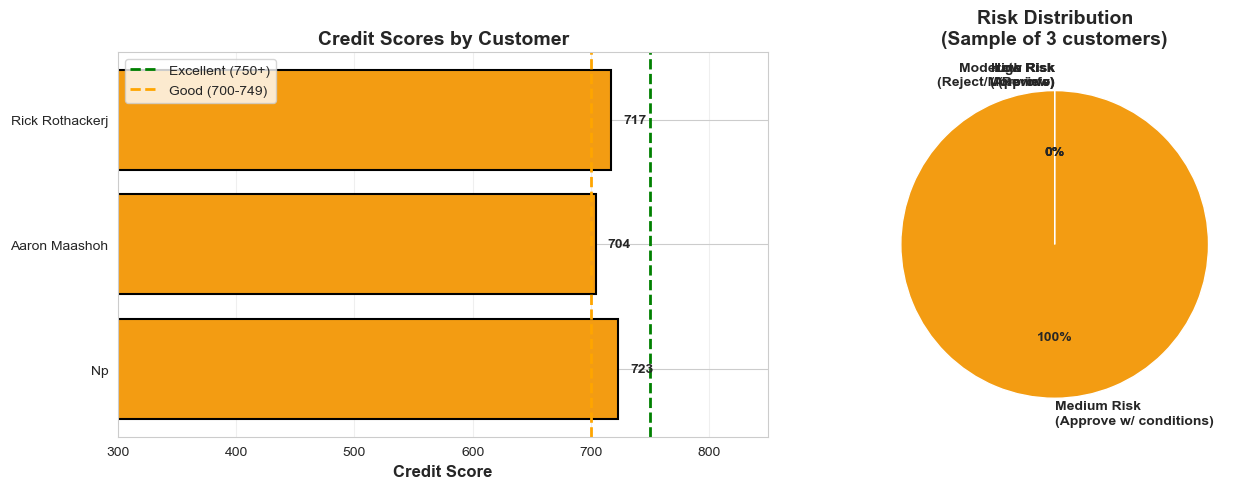


✓ Visualization complete!


In [12]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Credit Score Comparison
names = [r['name'] for r in results]
scores = [r['statistical_score']['score'] for r in results]
colors = ['#2ecc71' if s >= 750 else '#f39c12' if s >= 700 else '#e74c3c' for s in scores]

ax1 = axes[0]
bars = ax1.barh(names, scores, color=colors, edgecolor='black', linewidth=1.5)
ax1.axvline(x=750, color='green', linestyle='--', linewidth=2, label='Excellent (750+)')
ax1.axvline(x=700, color='orange', linestyle='--', linewidth=2, label='Good (700-749)')
ax1.set_xlabel('Credit Score', fontsize=12, fontweight='bold')
ax1.set_title('Credit Scores by Customer', fontsize=14, fontweight='bold')
ax1.set_xlim(300, 850)
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Add score labels on bars
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax1.text(score + 10, i, f'{score}', va='center', fontweight='bold')

# Plot 2: Risk Distribution
risk_categories = []
risk_counts = [0, 0, 0, 0]

for r in results:
    score = r['statistical_score']['score']
    if score >= 750:
        risk_counts[0] += 1
    elif score >= 700:
        risk_counts[1] += 1
    elif score >= 650:
        risk_counts[2] += 1
    else:
        risk_counts[3] += 1

ax2 = axes[1]
risk_labels = ['Low Risk\n(Approve)', 'Medium Risk\n(Approve w/ conditions)', 'Moderate Risk\n(Review)', 'High Risk\n(Reject/More info)']
risk_colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
ax2.pie(risk_counts, labels=risk_labels, colors=risk_colors, autopct='%1.0f%%',
        startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title('Risk Distribution\n(Sample of 3 customers)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

## Scoring Factors Explained

Our credit score is based on 5 key factors:

In [13]:
# Show factor importance
factors = {
    'Credit Utilization': {'weight': 50, 'meaning': 'How much of available credit is used (lower is better)'},
    'Recent Inquiries': {'weight': 40, 'meaning': 'How many recent credit inquiries (fewer is better)'},
    'Payment History': {'weight': 5, 'meaning': 'On-time payment ratio (higher is better)'},
    'Credit History Length': {'weight': 2.5, 'meaning': 'How long credit account is open (longer is better)'},
    'Outstanding Debt': {'weight': 2.5, 'meaning': 'Total outstanding debt (lower is better)'}
}

print("\nFACTOR IMPORTANCE:")
print("="*80)

import math
for factor, info in factors.items():
    weight = info['weight']
    meaning = info['meaning']
    # Show at least one block for small weights and cap to 10 blocks
    bar_len = min(10, max(1, int(math.ceil(weight / 5))))
    bar = '█' * bar_len
    print(f"\n{factor}")
    print(f"  Weight: {weight}% {bar}")
    print(f"  Meaning: {meaning}")

print("\n" + "="*80)
print(f"\nScore Range: 300 - 850 (standard credit score range)")
print(f"  🟢 750+     = Excellent (Low Risk)")
print(f"  🟡 700-749  = Good (Medium Risk)")
print(f"  🟠 650-699  = Fair (Moderate Risk)")
print(f"  🔴 Below 650 = Poor (High Risk)")


FACTOR IMPORTANCE:

Credit Utilization
  Weight: 50% ██████████
  Meaning: How much of available credit is used (lower is better)

Recent Inquiries
  Weight: 40% ████████
  Meaning: How many recent credit inquiries (fewer is better)

Payment History
  Weight: 5% █
  Meaning: On-time payment ratio (higher is better)

Credit History Length
  Weight: 2.5% █
  Meaning: How long credit account is open (longer is better)

Outstanding Debt
  Weight: 2.5% █
  Meaning: Total outstanding debt (lower is better)


Score Range: 300 - 850 (standard credit score range)
  🟢 750+     = Excellent (Low Risk)
  🟡 700-749  = Good (Medium Risk)
  🟠 650-699  = Fair (Moderate Risk)
  🔴 Below 650 = Poor (High Risk)


## Key Metrics & Insights

Let's analyze the overall data:

In [14]:
# Calculate statistics from all users
all_scores = []
all_incomes = []
all_debts = []

for user in all_users[:5000]:  # Sample of 5000 users
    score, tier, breakdown = calculate_statistical_credit_score(user)
    all_scores.append(score)
    all_incomes.append(user.get('Annual_Income', 0))
    all_debts.append(user.get('Outstanding_Debt', 0))

print("\n" + "="*60)
print("DATABASE STATISTICS (Sample of 5,000 customers)")
print("="*60)

print(f"\nCREDIT SCORES:")
print(f"  Average Score:     {np.mean(all_scores):.0f}")
print(f"  Median Score:      {np.median(all_scores):.0f}")
print(f"  Min Score:         {np.min(all_scores):.0f}")
print(f"  Max Score:         {np.max(all_scores):.0f}")

low_risk = sum(1 for s in all_scores if s >= 750) / len(all_scores) * 100
medium_risk = sum(1 for s in all_scores if 700 <= s < 750) / len(all_scores) * 100
high_risk = sum(1 for s in all_scores if s < 700) / len(all_scores) * 100

print(f"\nRISK DISTRIBUTION:")
print(f"  🟢 Low Risk (750+):      {low_risk:.1f}%")
print(f"  🟡 Medium Risk (700-749): {medium_risk:.1f}%")
print(f"  🔴 High Risk (<700):     {high_risk:.1f}%")

print(f"\nFINANCIAL METRICS:")
print(f"  Average Annual Income:   ${np.mean(all_incomes):,.0f}")
print(f"  Average Outstanding Debt: ${np.mean(all_debts):,.0f}")
print(f"  Debt-to-Income Ratio:    {(np.mean(all_debts) / np.mean(all_incomes) * 100):.1f}%")

print("\n" + "="*60)


DATABASE STATISTICS (Sample of 5,000 customers)

CREDIT SCORES:
  Average Score:     611
  Median Score:      614
  Min Score:         300
  Max Score:         767

RISK DISTRIBUTION:
  🟢 Low Risk (750+):      1.1%
  🟡 Medium Risk (700-749): 18.5%
  🔴 High Risk (<700):     80.4%

FINANCIAL METRICS:
  Average Annual Income:   $50,831
  Average Outstanding Debt: $1,420
  Debt-to-Income Ratio:    2.8%



## Business Impact & ROI

**Current State (Manual Process):**
- Time per application: 2-4 weeks
- Cost per application: $50-100
- Manual errors: 5-10%

**With Automated Scoring:**
- Time per application: **< 1 second**
- Cost per application: **< $0.01**
- Manual errors: **Near 0%** (algorithm is consistent)

**For 1,000 applications per month:**
- Time saved: 666-1,333 staff-hours
- Cost savings: $50,000-100,000
- Error reduction: 50-100 fewer mistakes

## Next Steps

1. **Integration**: Connect to your banking system for real-time scoring
2. **Customization**: Adjust weights based on your business rules
3. **ML Enhancement**: Add advanced models for even better predictions
4. **Scalability**: Deploy as API for all channels (web, mobile, branch)
5. **Monitoring**: Track model performance over time

---

**Ready to transform your credit assessment process?**